In [1]:
import numpy as np
import torch
import torchvision
import PIL.Image


class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/%s.csv' % part, delimiter=',')

        #数据增强模块,这里不需要什么太高级的变化
        self.transforms = torchvision.transforms.ToTensor()

    def __getitem__(self, idx):
        image = PIL.Image.open('data/%s/%s.jpg' % (self.part, idx))
        image = self.transforms(image)

        target = {
            'labels': torch.LongTensor([1]),
            'boxes': torch.LongTensor([self.data[idx] * 256])
        }

        return image, target

    def __len__(self):
        return len(self.data)


def collate_fn(data):
    images = [i[0] for i in data]
    targets = [i[1] for i in data]
    return images, targets


loader = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=collate_fn)

for step, (images, targets) in enumerate(loader):
    break

images[0].shape, targets

/root/anaconda3/envs/tt/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(torch.Size([3, 256, 256]),
 [{'labels': tensor([1]), 'boxes': tensor([[102,  77, 130, 112]])},
  {'labels': tensor([1]), 'boxes': tensor([[151,  87, 171, 117]])},
  {'labels': tensor([1]), 'boxes': tensor([[ 95, 108, 124, 143]])},
  {'labels': tensor([1]), 'boxes': tensor([[141,  98, 164, 131]])},
  {'labels': tensor([1]), 'boxes': tensor([[149,  82, 174, 122]])},
  {'labels': tensor([1]), 'boxes': tensor([[ 86,  89, 112, 127]])},
  {'labels': tensor([1]), 'boxes': tensor([[152,  92, 172, 121]])},
  {'labels': tensor([1]), 'boxes': tensor([[161,  94, 190, 136]])}])

In [2]:
transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(
    min_size=256,
    max_size=256,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225])

#把多张图片组合成一个tensor,格式为ImageList,是个torch自定的格式
#会按照transform变形,同时改变image和target的尺寸,算是个比较方便的工具
images, targets = transform(images, targets)

images.tensors.shape, targets

(torch.Size([8, 3, 256, 256]),
 [{'labels': tensor([1]), 'boxes': tensor([[102.,  77., 130., 112.]])},
  {'labels': tensor([1]), 'boxes': tensor([[151.,  87., 171., 117.]])},
  {'labels': tensor([1]), 'boxes': tensor([[ 95., 108., 124., 143.]])},
  {'labels': tensor([1]), 'boxes': tensor([[141.,  98., 164., 131.]])},
  {'labels': tensor([1]), 'boxes': tensor([[149.,  82., 174., 122.]])},
  {'labels': tensor([1]), 'boxes': tensor([[ 86.,  89., 112., 127.]])},
  {'labels': tensor([1]), 'boxes': tensor([[152.,  92., 172., 121.]])},
  {'labels': tensor([1]), 'boxes': tensor([[161.,  94., 190., 136.]])}])

In [3]:
import torchvision.models.detection._utils as det_utils

from rpn_utils import filter_proposals, assign_targets_to_anchors, compute_loss


class RPN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #定位框生成器,这里的size就是框的尺寸(绝对值),ratio = height / width
        #在特征图的每个像素点上生成1*1个定位框
        self.anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(
            sizes=((25, ), (25, )), aspect_ratios=((1.0, ), (1.0, )))

        self.box_coder = det_utils.BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

        self.conv = torch.nn.Conv2d(1280,
                                    1280,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)
        self.fc_scores = torch.nn.Conv2d(1280, 1, kernel_size=1, stride=1)
        self.fc_offsets = torch.nn.Conv2d(1280, 4, kernel_size=1, stride=1)

    def forward(self, images, features, targets=None):
        #images.tensors -> torch.Size([8, 3, 256, 256])
        #features -> [torch.Size([8, 1280, 8, 8]),torch.Size([8, 1280, 8, 8])]
        #targets -> [{'labels': tensor([1]), 'boxes': tensor([[135., 106., 160., 143.]])}, * 8]

        #features现在是一个字典,这里只要value,把value组合成一个list
        features = list(features.values())

        #对每一个特征图的每一个像素,分别计算1个分数和4个偏移量
        #scores -> [[b,1,特征图宽高] * 特征图数量] -> [torch.Size([8, 1, 8, 8]),torch.Size([8, 1, 8, 8])]
        #offsets -> 4个数字分别代表xy偏移量,wh缩放比例 -> [[b,4,特征图宽高] * 特征图数量] -> [torch.Size([8, 4, 8, 8]),torch.Size([8, 4, 8, 8])]
        features_conv = [
            torch.nn.functional.relu(self.conv(i)) for i in features
        ]
        scores = [self.fc_scores(i) for i in features_conv]
        offsets = [self.fc_offsets(i) for i in features_conv]
        del features_conv

        #在每个特征图的每个像素上生成1个定位框,为什么是1,因为是1个尺寸*1个比例
        #anchors -> [[1*特征图宽高*特征图数量] * b] -> [torch.Size([128, 4]) * 8]
        anchors = self.anchor_generator(images, features)

        #其实整个过程就是变形,没有什么实质性的计算
        #scores -> torch.Size([1024, 1])
        #offsets -> torch.Size([1024, 4])
        scores, offsets = torchvision.models.detection.rpn.concat_box_prediction_layers(
            scores, offsets)

        #使用计算出来的偏移量对生成框进行偏移,得到预测框
        boxes = self.box_coder.decode(offsets.detach(), anchors)
        #torch.Size([1024, 1, 4]) -> torch.Size([8, 128, 4])
        boxes = boxes.view(len(anchors), -1, 4)

        #对计算出来的框,按照分数过滤,
        #并且移除重复度太高的框,只保留激活分最高的那一个
        #对框裁剪,让所有的框在图片范围内
        #移除长或者宽太小的框
        #[64,64]是每张特征图上的框的数量
        boxes, _ = filter_proposals(boxes, scores, images.image_sizes,
                                    [64, 64])

        loss_scores = 0
        loss_offsets = 0
        if self.training:
            #scores_y,只有[-1,0,1]三个内容, 分别代表 弱负, 负, 正样例.[[128个数字], * 8]
            #matched_targets,每个anchro对应的target,[torch.Size([128, 4]) * 8]
            scores_y, matched_targets = assign_targets_to_anchors(
                anchors, targets)

            #求每个一个anchro和他的target的差
            offsets_y = self.box_coder.encode(matched_targets, anchors)

            #计算loss,其中loss_scores计算的是交叉熵,loss_offset计算的是l1loss
            #loss_scores当中包括[-1,0,1]三个内容,在计算loss的时候会去除-1的项目,也就是弱负例
            loss_scores, loss_offsets = compute_loss(scores, offsets, scores_y,
                                                     offsets_y)

        return boxes, loss_scores, loss_offsets


#虚拟一个特征图
features = {'0': torch.randn(8, 1280, 8, 8), '1': torch.randn(8, 1280, 8, 8)}

#rpn的计算结果是boxes,这些框并没有明确的label,只是简单的区分前景和背景
#这些框会作为roi的输入,在roi当中进一步删选并判断label
boxes_rpn, _, _ = RPN()(images, features, targets)

len(boxes_rpn), boxes_rpn[0].shape

/root/anaconda3/envs/tt/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(8, torch.Size([100, 4]))

In [4]:
from roi_utils import select_training_samples, fastrcnn_loss, postprocess_detections


class ROI(torch.nn.Module):
    def __init__(self):
        super().__init__()

        pool_size = 3
        self.box_head = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(1280 * pool_size**2, 1024), torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024), torch.nn.ReLU())

        self.roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=[pool_size, pool_size],
            sampling_ratio=2)

        self.fc_labels = torch.nn.Linear(1024, 2)
        self.fc_offsets = torch.nn.Linear(1024, 2 * 4)

    def forward(self, features, boxes, image_shapes, targets=None):
        #features -> {'0':torch.Size([8, 1280, 8, 8]),'1':torch.Size([8, 1280, 8, 8])}, 特征图
        #boxes -> [torch.Size([100, 4]), * 8], 计算出来的框, 已经过滤过了, 但不一样都是正例, 这里的框似乎和正例负例没有关系
        #image_shapes -> [(256, 256), * 8], 原始图像尺寸
        #targets -> [{'labels': tensor([1]), 'boxes': tensor([[149.,  83., 177., 126.]])} * 8]

        if self.training:
            #去除了弱负例,同时采样,减少数量
            #经过过滤后,都只会剩下roi_utils.box_batch_size_per_image个

            #把target也加入到box列表中,计算两两的iou
            #这些值一定是1, 因为这些box就是target本身
            #ious[0,-8]==1,ious[1,-7]==1,ious[2,-6]==1...

            #把iou高于阈值的置为正例,否则置为负例
            #负例的label是0,正例的label大于0,对应了每一个类别
            #还有一种是弱负例,会被直接丢弃掉,所以只有正例和负例参与后续的计算

            #返回值中的box就是经过过滤的预测框
            #第二个返回值没有用,直接忽略
            #labels_y是每个box对应的label,负例对应的就是0了,也就是背景
            #offsets_y计算每个box和它对应的target之间的偏移量,这个所谓的对应的target,指的是iou意义上最相近的target
            #其中负例计算的是和第0个target的偏移量,这个好像没有意义

            #boxes -> [torch.Size([101, 4]) * 8]
            #labels_y -> [[101] * 8]
            #offsets_y -> [torch.Size([101, 4]) * 8]

            #其中每个boxes的最后一个元素,一定是对应下标的target
            #比如第0个boxes的最后一个元素,一定就是第0个target
            boxes, _, labels_y, offsets_y = select_training_samples(
                boxes, targets)

        #因为特征图的尺寸是不确定的,取决于使用的backbone.所以这里要把特征图变形成确定的形状.
        #{'0':torch.Size([8, 1280, 8, 8]),'1':torch.Size([8, 1280, 8, 8])} -> torch.Size([808, 1280, 3, 3])
        #其中808是因为有101*8个框,1280是特征图的通道数,3*3是参数
        #虽然这个模块看起来很像一个神经网络,但其实他并不含有任何参数,不需要学习
        features = self.roi_pooler(features, boxes, image_shapes)

        #线性运算 torch.Size([808, 1280, 3, 3]) -> torch.Size([808, 1024])
        features = self.box_head(features)

        #两个线性运算
        #labels -> torch.Size([808, 1024]) -> torch.Size([808, 2])
        #offsets -> torch.Size([808, 1024]) -> torch.Size([808, 8])
        features = features.flatten(start_dim=1)
        labels = self.fc_labels(features)
        offsets = self.fc_offsets(features)
        del features

        result = []
        loss_labels = 0
        loss_offsets = 0
        if self.training:
            #计算loss,其中loss_scores计算的是交叉熵,loss_offset计算的是l1loss
            #在计算loss_offsets的时候只计算正例的,排除了负例
            loss_labels, loss_offsets = fastrcnn_loss(labels, offsets,
                                                      labels_y, offsets_y)
        else:
            #简单的说就是过滤计算出来的框,移除太小的,重复度太高了,置信度太低的,诸如此类
            boxes, scores, labels = postprocess_detections(
                labels, offsets, boxes, image_shapes)
            for i in range(len(boxes)):
                result.append({
                    "boxes": boxes[i],
                    "labels": labels[i],
                    "scores": scores[i],
                })

        return result, loss_labels, loss_offsets


#对rpn计算出来的框进一步删选并计算label
boxes_roi, _, _ = ROI()(features, boxes_rpn, images.image_sizes, targets)

len(boxes_roi)

0

In [5]:
from collections import OrderedDict


class FasterRCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #就是个简单的cnn网络
        self.backbone = torchvision.models.mobilenet_v2(
            pretrained=True).features

        self.rpn = RPN()
        self.roi = ROI()

    def forward(self, images, targets=None):

        #首先对图片计算特征图,这就是经过一个简单的cnn网络就可以做到了
        #torch.Size([8, 3, 256, 256]) -> torch.Size([8, 1280, 8, 8])
        features = self.backbone(images.tensors)

        #输出是个tensor,把它封装成一个dict,这里具体输出什么格式取决于backbone,总之就是统一不同的输出格式
        #因为在我这个例子当中,backbone只会输出一层特征图,所以为了模拟有多张特征图的情况,把这一张特征图重复两次
        features = OrderedDict([('0', features), ('1', features)])

        #先输入rpn当中计算前景背景框
        boxes, loss_scores, loss_offsets_rpn = self.rpn(
            images, features, targets)

        #再输入roi当中进一步删选每个框,并计算label
        boxes, loss_labels, loss_offsets_roi = self.roi(
            features, boxes, images.image_sizes, targets)

        if self.training:
            return loss_scores, loss_offsets_rpn, loss_labels, loss_offsets_roi

        return boxes


FasterRCNN()(images, targets)

(tensor(0.6414, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.0193, grad_fn=<DivBackward0>),
 tensor(0.6704, grad_fn=<NllLossBackward0>),
 tensor(0.0114, grad_fn=<DivBackward0>))

In [6]:
def train(params):
    optimizer = torch.optim.SGD(params, lr=1e-2)
    for epoch in range(10):
        for step, (images, targets) in enumerate(loader):

            #把多张图片组合成一个tensor,格式为ImageList
            images, targets = transform(images, targets)

            #模型计算,得到4个loss
            loss_scores, loss_offsets_rpn, loss_labels, loss_offsets_roi = model(
                images, targets)

            #最终的loss就是对这4个loss简单的求和
            loss = loss_scores + loss_offsets_rpn + loss_labels + loss_offsets_roi

            #梯度下降
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step % 20 == 0:
                print(epoch, step, loss.item())

        torch.save(model, 'my_rcnn.model')


model = FasterRCNN()
model.train()
params = [p for p in model.parameters() if p.requires_grad]

#输出参数量
print(sum(p.numel() for p in params) / 10000)

#train(params)

2983.4511


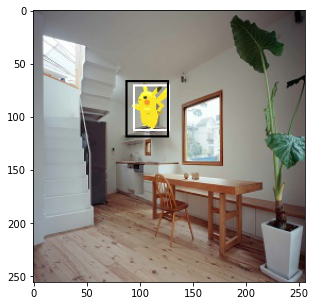

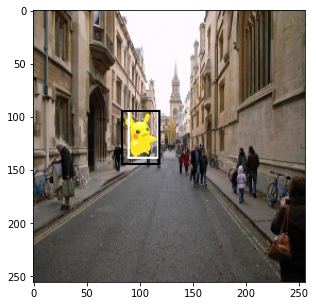

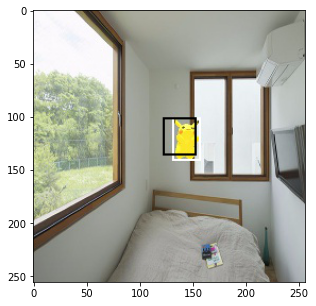

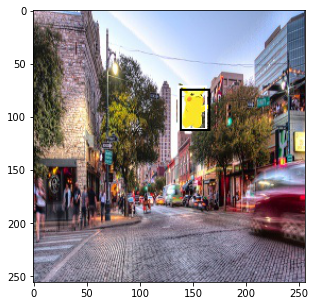

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(image, target, out):
    image = image.detach().numpy() * 255.0
    image = image.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    image = image.transpose((1, 0, 2))
    image = image.transpose((0, 2, 1))

    target = target.detach().tolist()

    image = PIL.Image.fromarray(image)
    draw = PIL.ImageDraw.Draw(image)

    draw.rectangle(xy=target, outline='white', width=2)

    if out and len(out['scores']) > 0:
        idx = out['scores'].argmax().item()
        draw.rectangle(xy=out['boxes'][idx].tolist(), outline='black', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


def test():
    loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                              batch_size=4,
                                              shuffle=True,
                                              drop_last=True,
                                              collate_fn=collate_fn)

    for i, (images, targets) in enumerate(loader_test):
        break

    #把多张图片组合成一个tensor,格式为ImageList
    image_list, targets = transform(images, targets)

    model_load = torch.load('my_rcnn.model')
    model_load.eval()

    with torch.no_grad():
        outs = model_load(image_list)

    #把计算出来的box还原成原图的尺寸大小
    original_image_sizes = [(256, 256)] * 4
    transform_image_sizes = [(256, 256)] * 4
    outs = transform.postprocess(outs, transform_image_sizes,
                                 original_image_sizes)

    for i in range(4):
        show(images[i], targets[i]['boxes'][0], outs[i])


test()